In [ ]:
# Import libs
import sys
import os
import pandas as pd
from datetime import datetime
import shapely 
import h3

# Add custom libs
sys.path.append(os.path.expanduser('~/libs'))
from geotools import *

# settings
ansp = [
    'https://raw.githubusercontent.com/euctrl-pru/pruatlas/master/data/ansps_ace_406.parquet',
    'https://raw.githubusercontent.com/euctrl-pru/pruatlas/master/data/ansps_ace_481.parquet']
firs = [
    'https://raw.githubusercontent.com/euctrl-pru/pruatlas/master/data/firs_nm_406.parquet',
    'https://raw.githubusercontent.com/euctrl-pru/pruatlas/master/data/firs_nm_481.parquet']
countries = [
    'https://raw.githubusercontent.com/euctrl-pru/pruatlas/master/data/countries50m.parquet']

# Helper functions

def fill_geometry(geometry, res = 7):
     return [h3.polyfill(shapely.geometry.mapping(x), res, geo_json_conformant=True) for x in shapely.wkt.loads(geometry).geoms]

def fill_geometry_compact(geometry, res = 7):
     return [h3.compact(h3.polyfill(shapely.geometry.mapping(x), res, geo_json_conformant=True)) for x in shapely.wkt.loads(geometry).geoms]

def process_ansp_airspaces(filepath, compact = False):
    ansp_df = pd.read_parquet(filepath)
    
    cfmu_airac = {
        406 : [datetime(2015, 11, 12), datetime(2015, 12, 10)],
        481 : [datetime(2021, 8, 12), datetime(2021,9, 9)]
    }
    
    ansp_df['validity_start'] = ansp_df.airac_cfmu.apply(lambda l: cfmu_airac[l][0])
    ansp_df['validity_end'] = ansp_df.airac_cfmu.apply(lambda l: cfmu_airac[l][1])
    
    ansp_df = ansp_df[[
        'airspace_type',
        'name',
        'code',
        'airac_cfmu',
        'validity_start',
        'validity_end',
        'min_fl',
        'max_fl',
        'geometry_wkt'
    ]]
    if compact:
        ansp_df.loc[:, 'h3_res_7'] = ansp_df.geometry_wkt.apply(lambda l: fill_geometry_compact(l))
    else:
        ansp_df.loc[:, 'h3_res_7'] = ansp_df.geometry_wkt.apply(lambda l: fill_geometry(l))
    ansp_df = ansp_df.loc[:, ansp_df.columns != 'geometry_wkt'] 
    ansp_df = ansp_df.explode('h3_res_7').explode('h3_res_7')
    return ansp_df


def process_fir_airspaces(filepath, compact = False):
    fir_df = pd.read_parquet(filepath)
    cfmu_airac = {
        406 : [datetime(2015, 11, 12), datetime(2015, 12, 10)],
        481 : [datetime(2021, 8, 12), datetime(2021,9, 9)]
    }
    
    fir_df['validity_start'] = fir_df.airac_cfmu.apply(lambda l: cfmu_airac[l][0])
    fir_df['validity_end'] = fir_df.airac_cfmu.apply(lambda l: cfmu_airac[l][1])
    
    fir_df = fir_df.rename({'id':'code'},axis=1)
    
    fir_df = fir_df[[
        'airspace_type',
        'name',
        'code',
        'airac_cfmu',
        'validity_start',
        'validity_end',
        'min_fl',
        'max_fl',
        'geometry_wkt'
    ]]
    
    if compact:
        fir_df.loc[:, 'h3_res_7'] = fir_df.geometry_wkt.apply(lambda l: fill_geometry_compact(l))
    else:
        fir_df.loc[:, 'h3_res_7'] = fir_df.geometry_wkt.apply(lambda l: fill_geometry(l))
    fir_df = fir_df.loc[:, fir_df.columns != 'geometry_wkt'] 
    fir_df = fir_df.explode('h3_res_7').explode('h3_res_7')
    return fir_df

def process_country_airspace(filepath, compact = False):
    ctry_df = pd.read_parquet(filepath)
    
    ctry_df = ctry_df.rename({
        'admin':'name',
        'iso_a3':'code'
    }, axis = 1)
    ctry_df['min_fl'] = 0
    ctry_df['max_fl'] = 999
    ctry_df['airac_cfmu'] = -1
    ctry_df['validity_start'] = datetime(1900,1,1)
    ctry_df['validity_end'] = datetime(2100,1,1)
    ctry_df['airspace_type'] = 'COUNTRY'
    
    ctry_df = ctry_df[[
        'airspace_type',
        'name',
        'code',
        'airac_cfmu',
        'validity_start',
        'validity_end',
        'min_fl',
        'max_fl',
        'geometry_wkt'
    ]]
    
    if compact:
        ctry_df.loc[:, 'h3_res_7'] = ctry_df.geometry_wkt.apply(lambda l: fill_geometry_compact(l))
    else:
        ctry_df.loc[:, 'h3_res_7'] = ctry_df.geometry_wkt.apply(lambda l: fill_geometry(l))
    ctry_df = ctry_df.loc[:, ctry_df.columns != 'geometry_wkt'] 
    ctry_df = ctry_df.explode('h3_res_7').explode('h3_res_7')
    return ctry_df

# Processing part
for filepath in ansp:
    print(f"Processing: {filepath}")
    # Uncompacted data goes in the database
    #df = process_ansp_airspaces(filepath, compact = False)
    ## .. write to db .. ## 
    
    # Compacted data goes to a file for inspection
    dest = "~/data/airspace_data/ansp/"
    output_path = f"{dest}/{filepath.split('/')[-1].split('.')[0]}_h3_compact.parquet"
    df = process_ansp_airspaces(filepath, compact = False)
    df.to_parquet(output_path)

for filepath in fir:
    print(f"Processing: {filepath}")
    # Uncompacted data goes in the database
    #df = process_fir_airspaces(filepath, compact = False)
    ## .. write to db .. ## 
    
    # Compacted data goes to a file for inspection
    dest = "~/data/airspace_data/fir/"
    output_path = f"{dest}/{filepath.split('/')[-1].split('.')[0]}_h3_compact.parquet"
    df = process_ansp_airspaces(filepath, compact = False)
    df.to_parquet(output_path)

for filepath in countries:
    print(f"Processing: {filepath}")
    # Uncompacted data goes in the database
    #df = process_fir_airspaces(filepath, compact = False)
    ## .. write to db .. ## 
    
    # Compacted data goes to a file for inspection
    dest = "~/data/airspace_data/countries/"
    output_path = f"{dest}/{filepath.split('/')[-1].split('.')[0]}_h3_compact.parquet"
    df = process_ansp_airspaces(filepath, compact = False)
    df.to_parquet(output_path)

Processing: https://raw.githubusercontent.com/euctrl-pru/pruatlas/master/data/ansps_ace_406.parquet


In [54]:
%%time
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon
import shapely

# Export for dump in database
df = pd.read_parquet('/home/cdsw/data/metadata/pruatlas/countries50m.parquet')

CPU times: user 13.4 ms, sys: 3.84 ms, total: 17.2 ms
Wall time: 63.5 ms


In [36]:


def fill_geometry(geometry, res = 7):
     return [h3.polyfill(shapely.geometry.mapping(x), res, geo_json_conformant=True) for x in shapely.wkt.loads(geometry).geoms]

df.loc[:, 'hex_ids'] = df.geometry_wkt.apply(lambda l: fill_geometry(l))

df = df.loc[:, df.columns != 'geometry_wkt'] 
df = df.explode('hex_ids').explode('hex_ids')

# Export for visualization & Inspection
df = pd.read_parquet('/home/cdsw/data/metadata/pruatlas/firs_nm_481.parquet')


df.loc[:, 'hex_ids'] = df.geometry_wkt.apply(lambda l: fill_geometry(l))

df = df.loc[:, df.columns != 'geometry_wkt'] 
df = df.explode('hex_ids').explode('hex_ids')

CPU times: user 6min 51s, sys: 19.3 s, total: 7min 10s
Wall time: 7min 9s


In [38]:
df

,airac_cfmu,icao,id,name,min_fl,max_fl,airspace_type,hex_ids
0,406,EN,ENORFIR,,0,999,FIR,870820741ffffff
0,406,EN,ENORFIR,,0,999,FIR,8708ec753ffffff
0,406,EN,ENORFIR,,0,999,FIR,870990711ffffff
0,406,EN,ENORFIR,,0,999,FIR,870953741ffffff
0,406,EN,ENORFIR,,0,999,FIR,87099b118ffffff
...,...,...,...,...,...,...,...,...
150,406,UC,UCFFFIR,KYRGYZSTAN MERGED FIRS,0,999,FIR,85201e2ffffffff
150,406,UC,UCFFFIR,KYRGYZSTAN MERGED FIRS,0,999,FIR,8720c4c8effffff
150,406,UC,UCFFFIR,KYRGYZSTAN MERGED FIRS,0,999,FIR,8720ae00effffff
150,406,UC,UCFFFIR,KYRGYZSTAN MERGED FIRS,0,999,FIR,8720e2b62ffffff


In [37]:
df.to_parquet('h3test.parquet')

In [3]:
%%time
cells = df.hex_ids.to_list()
cells = [x for x in cells if type(x) == str]

CPU times: user 15.4 s, sys: 248 ms, total: 15.6 s
Wall time: 15.6 s


In [4]:
%%time
shp = h3.h3_set_to_multi_polygon(cells)

CPU times: user 8min 23s, sys: 3.1 s, total: 8min 27s
Wall time: 8min 25s


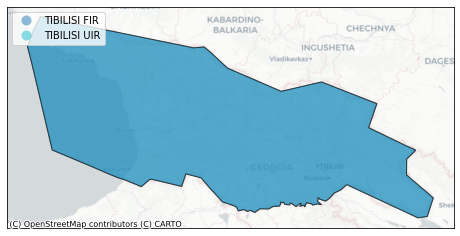

In [56]:
plot_df(gdf[gdf.icao == 'UG'], column='name')

,airac_cfmu,icao,id,name,min_fl,max_fl,airspace_type,geometry
0,406,EN,ENORFIR,,0,999,FIR,"MULTIPOLYGON (((30.908 70.672, 30 71, 29.984 7..."
1,406,XX,XXXXFIR,FIR XX,0,999,FIR,"MULTIPOLYGON (((-178 -88, -179 -88, -179 -89, ..."
2,406,SB,SBBBFIR,SOUTH AMERICA,0,999,FIR,"MULTIPOLYGON (((-120 -7.5, -120 -89, -10 -89, ..."
3,406,UT,UTAAFIR,TURKMENISTAN FIR,0,999,FIR,"MULTIPOLYGON (((66.533 37.367, 66.667 38, 66.0..."
4,406,UT,UTAKFIR,TURKMENBASHI FIR,0,999,FIR,"MULTIPOLYGON (((56.417 40.083, 57.583 40.667, ..."
...,...,...,...,...,...,...,...,...
146,406,LS,LSASFIR,SWITZERLAND FIR,0,195,FIR,"MULTIPOLYGON (((8.892 47.657, 8.631 47.768, 8...."
147,406,UG,UGGGFIR,TIBILISI FIR,0,195,FIR,"MULTIPOLYGON (((46.444 41.888, 46.45 41.9, 46...."
148,406,UK,UKOVFIR,ODESSA FIR,0,275,FIR,"MULTIPOLYGON (((32.94 47.098, 33.05 47.733, 32..."
149,406,KZ,KZWYFIR,NEW YORK OCEANIC,0,999,FIR,"MULTIPOLYGON (((-77 32.25, -77 30, -77 29, -77..."


In [19]:
df

,airac_cfmu,icao,id,name,min_fl,max_fl,airspace_type,geometry_wkt,geometry
0,406,EN,ENORFIR,,0,999,FIR,"MULTIPOLYGON (((30.908 70.672, 30 71, 29.984 7...","MULTIPOLYGON (((30.908 70.672, 30 71, 29.984 7..."
1,406,XX,XXXXFIR,FIR XX,0,999,FIR,"MULTIPOLYGON (((-178 -88, -179 -88, -179 -89, ...","MULTIPOLYGON (((-178 -88, -179 -88, -179 -89, ..."
2,406,SB,SBBBFIR,SOUTH AMERICA,0,999,FIR,"MULTIPOLYGON (((-120 -7.5, -120 -89, -10 -89, ...","MULTIPOLYGON (((-120 -7.5, -120 -89, -10 -89, ..."
3,406,UT,UTAAFIR,TURKMENISTAN FIR,0,999,FIR,"MULTIPOLYGON (((66.533 37.367, 66.667 38, 66.0...","MULTIPOLYGON (((66.533 37.367, 66.667 38, 66.0..."
4,406,UT,UTAKFIR,TURKMENBASHI FIR,0,999,FIR,"MULTIPOLYGON (((56.417 40.083, 57.583 40.667, ...","MULTIPOLYGON (((56.417 40.083, 57.583 40.667, ..."
...,...,...,...,...,...,...,...,...,...
146,406,LS,LSASFIR,SWITZERLAND FIR,0,195,FIR,"MULTIPOLYGON (((8.892 47.657, 8.631 47.768, 8....","MULTIPOLYGON (((8.892 47.657, 8.631 47.768, 8...."
147,406,UG,UGGGFIR,TIBILISI FIR,0,195,FIR,"MULTIPOLYGON (((46.444 41.888, 46.45 41.9, 46....","MULTIPOLYGON (((46.444 41.888, 46.45 41.9, 46...."
148,406,UK,UKOVFIR,ODESSA FIR,0,275,FIR,"MULTIPOLYGON (((32.94 47.098, 33.05 47.733, 32...","MULTIPOLYGON (((32.94 47.098, 33.05 47.733, 32..."
149,406,KZ,KZWYFIR,NEW YORK OCEANIC,0,999,FIR,"MULTIPOLYGON (((-77 32.25, -77 30, -77 29, -77...","MULTIPOLYGON (((-77 32.25, -77 30, -77 29, -77..."


In [12]:
df.geometry_wkt.values[0]

'MULTIPOLYGON (((30.908 70.672, 30 71, 29.984 71.003, 29.698 71.053, 28 71.333, 27.598 71.333, 27.352 71.333, 26.864 71.333, 26.343 71.333, 25 71.333, 24.639 71.297, 24 71.212, 23.5 71.157, 22.942 71.116, 21.254 70.918, 19.011 70.622, 18.545 70.557, 18 70.467, 16.296 70.215, 16.216 70.202, 15 70, 14.333 69.715, 14.041 69.586, 13.823 69.488, 13.438 69.314, 12.807 69.02, 11.829 68.543, 11.738 68.498, 11.178 68.2, 10.961 68.097, 10.576 67.892, 10.305 67.745, 9.724 67.422, 9.421 67.25, 9.18 67.109, 9.059 67.039, 8.607 66.769, 8.108 66.463, 7.972 66.38, 7.708 66.211, 7.441 66.04, 7 65.75, 6.887 65.657, 6.841 65.618, 6.772 65.55, 6.304 65.165, 6.267 65.133, 6.263 65.129, 5.799 64.723, 5.566 64.514, 5.478 64.429, 5.427 64.386, 5.298 64.266, 5.093 64.073, 5 64, 4.801 63.796, 4.719 63.717, 4.563 63.567, 4.553 63.555, 4.356 63.36, 4.233 63.237, 4.205 63.208, 4.106 63.108, 4.075 63.071, 4 63, 3.717 63, 3.066 63, 2 63, 1.278 63, 0.524 63, 0.033 63, 0 63.017, 0 63, 0 62.435, 0 62, 0 61.529, 0 61.5,

In [4]:

pyreadr.read_r()

Signature: pyreadr.read_r(path, use_objects=None, timezone=None)
Docstring:
Read an R RData or Rds file into pandas data frames

Parameters
----------
    path : str
        path to the file. The string is assumed to be utf-8 encoded.
    use_objects : list, optional
        a list with object names to read from the file. Only those objects will be imported. Case sensitive!
    timezone : str, optional
        timezone to localize datetimes, UTC otherwise.
        R datetimes (POSIXct and POSIXlt) are stored as UTC, but coverted to some timezone (explicitly if set by the
        user or implicitly to local zone) when displaying it in R. librdata cannot recover that timezone information
        therefore timestamps are displayed in UTC, unless this parameter is set.

Returns
-------
    result : OrderedDict
        object name as key and pandas data frame as value
File:      ~/.local/lib/python3.10/site-packages/pyreadr/pyreadr.py
Type:      function

In [ ]:
import pyreadr

result = pyreadr.read_r('/path/to/file.RData') # also works for Rds, rda

# done! let's see what we got
# result is a dictionary where keys are the name of objects and the values python
# objects
print(result.keys()) # let's check what objects we got
df1 = result["df1"] # extract the pandas data frame for object df1

In [ ]:
import pandas as pd
import numpy as np
import json
import math
import pandas as pd
pd.DataFrame.iteritems = pd.DataFrame.items

from datetime import datetime, timedelta
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import udf, col, lit, array_except
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
import h3
import h3_pyspark
#.config("spark.ui.showConsoleProgress", "false") \
# Spark Session Initialization
spark = SparkSession.builder \
    .appName("OPDI Flight Table") \
    .config("spark.hadoop.fs.azure.ext.cab.required.group", "eur-app-opdi") \
    .config("spark.kerberos.access.hadoopFileSystems", "abfs://storage-fs@cdpdllive.dfs.core.windows.net/data/project/opdi.db/unmanaged") \
    .config("spark.executor.extraClassPath", "/opt/spark/optional-lib/iceberg-spark-runtime-3.3_2.12-1.3.1.1.20.7216.0-70.jar") \
    .config("spark.driver.extraClassPath", "/opt/spark/optional-lib/iceberg-spark-runtime-3.3_2.12-1.3.1.1.20.7216.0-70.jar") \
    .config("spark.sql.catalog.spark_catalog.type", "hive") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkSessionCatalog") \
    .config("spark.sql.iceberg.handle-timestamp-without-timezone", "true") \
    .config("spark.sql.catalog.spark_catalog.warehouse", "abfs://storage-fs@cdpdllive.dfs.core.windows.net/data/project/opdi.db/unmanaged") \
    .config("spark.executor.instances", "3") \
    .config("spark.dynamicAllocation.maxExecutors", "20") \
    .config("spark.network.timeout", "800s") \
    .config("spark.executor.heartbeatInterval", "400s") \
    .enableHiveSupport() \
    .getOrCreate()


def generate_circle_polygon(lon, lat, radius_nautical_miles, num_points=360):
    """
    Generate a polygon in GeoJSON format around a given latitude and longitude
    with a specified radius in nautical miles.
    """
    radius_km = radius_nautical_miles * 1.852
    
    def degrees_to_radians(degrees):
        return degrees * math.pi / 180
    
    def calculate_point(lon, lat, distance_km, bearing):
        R = 6371.01  # Earth's radius in kilometers
        lat_rad = degrees_to_radians(lat)
        lon_rad = degrees_to_radians(lon)
        distance_rad = distance_km / R
        bearing_rad = degrees_to_radians(bearing)
        
        lat_new_rad = math.asin(math.sin(lat_rad) * math.cos(distance_rad) +
                                math.cos(lat_rad) * math.sin(distance_rad) * math.cos(bearing_rad))
        lon_new_rad = lon_rad + math.atan2(math.sin(bearing_rad) * math.sin(distance_rad) * math.cos(lat_rad),
                                           math.cos(distance_rad) - math.sin(lat_rad) * math.sin(lat_new_rad))
        
        return [math.degrees(lon_new_rad), math.degrees(lat_new_rad)]
    
    points = [calculate_point(lon, lat, radius_km, (360 / num_points) * i) for i in range(num_points)]
    points.append(points[0])  # Close the polygon
    
    return json.dumps({"type": "Polygon", "coordinates": [points]})


generate_circle_polygon_udf = udf(generate_circle_polygon, StringType())

df_apt = pd.read_csv('https://davidmegginson.github.io/ourairports-data/airports.csv')

offset = 3  # degrees
f_lat = (df_apt.latitude_deg.between(26.74617 - offset, 70.25976 + offset))
f_lon = (df_apt.longitude_deg.between(-25.86653 - offset, 49.65699 + offset))
df_apt = df_apt[f_lat & f_lon]

# Convert column names to string type to avoid issues
df_apt.columns = df_apt.columns.astype(str)

# Cast numerical columns to float explicitly to avoid conversion issues
df_apt = df_apt.astype({
    "latitude_deg": "float64",
    "longitude_deg": "float64",
    "elevation_ft": "float64"  # In case elevation is present
})


# Define schema for PySpark DataFrame
schema = StructType([
    StructField("id", StringType(), True),
    StructField("ident", StringType(), True),
    StructField("type", StringType(), True),
    StructField("name", StringType(), True),
    StructField("latitude_deg", FloatType(), True),
    StructField("longitude_deg", FloatType(), True),
    StructField("elevation_ft", FloatType(), True),
    StructField("continent", StringType(), True),
    StructField("iso_country", StringType(), True),
    StructField("iso_region", StringType(), True),
    StructField("municipality", StringType(), True),
    StructField("scheduled_service", StringType(), True),
    StructField("gps_code", StringType(), True),
    StructField("iata_code", StringType(), True),
    StructField("local_code", StringType(), True),
    StructField("home_link", StringType(), True),
    StructField("wikipedia_link", StringType(), True),
    StructField("keywords", StringType(), True),
])

# Convert pandas DataFrame to PySpark DataFrame using schema
airports_df = spark.createDataFrame(df_apt, schema=schema)

max_resolution = 7
num_points = 720
radia_nm = [0, 5, 10, 20, 30, 40]
area_type = [f"C{x+10}" for x in radia_nm]

df = pd.DataFrame({
    'max_resolution': max_resolution,
    'number_of_points_c': num_points,
    'area_type': area_type,
    'min_c_radius_nm': radia_nm
})

df['max_c_radius_nm'] = df['min_c_radius_nm'].shift(-1).fillna(np.max(radia_nm) + 10)
df[['min_c_radius_nm', 'max_c_radius_nm']] = df[['min_c_radius_nm', 'max_c_radius_nm']].astype(float)
df['m_col'] = 1

schema = StructType([
    StructField("max_resolution", IntegerType(), True),
    StructField("number_of_points_c", IntegerType(), True),
    StructField("area_type", StringType(), True),
    StructField("min_c_radius_nm", FloatType(), True),
    StructField("max_c_radius_nm", FloatType(), True),
    StructField("m_col", IntegerType(), True)
])

sdf = spark.createDataFrame(df, schema=schema)
airports_df_m = airports_df.withColumn('m_col', lit(1)).join(sdf, on='m_col', how='left')

res = (airports_df_m
    .withColumn("inner_circle_polygon", generate_circle_polygon_udf(col('longitude_deg'), col('latitude_deg'), col('min_c_radius_nm'), col('number_of_points_c')))
    .withColumn("outer_circle_polygon", generate_circle_polygon_udf(col('longitude_deg'), col('latitude_deg'), col('max_c_radius_nm'), col('number_of_points_c')))
    .withColumn("inner_circle_hex_ids", h3_pyspark.polyfill(col("inner_circle_polygon"), col("max_resolution"), lit(True)))
    .withColumn("outer_circle_hex_ids", h3_pyspark.polyfill(col("outer_circle_polygon"), col("max_resolution"), lit(True)))
    .withColumn("hex_id", array_except(col("outer_circle_hex_ids"), col("inner_circle_hex_ids")))
    .drop("inner_circle_polygon", "outer_circle_polygon", "inner_circle_hex_ids", "outer_circle_hex_ids")
    .toPandas()
)

res.to_parquet('../../data/airport_hex/airport_concentric_c_hex_res_7_new.parquet')

Setting spark.hadoop.yarn.resourcemanager.principal to quinten.goens


In [ ]:
import pandas as pd

from pyspark.sql.types import DoubleType, ArrayType, StructType, StructField, StringType, IntegerType, FloatType

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,from_unixtime, min, max, to_date, pandas_udf, col, PandasUDFType, lit, round, array_except
from pyspark.sql.types import DoubleType, ArrayType, StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql import functions as F
from pyspark.sql import Window

import os, time
import subprocess
import os,shutil
from datetime import datetime
import pandas as pd
import numpy as np
from IPython.display import display, HTML

import requests
from shapely.geometry import LineString, Polygon
from shapely.ops import transform
import pyproj
from functools import partial
from shapely.geometry import LineString
from shapely.ops import transform
from pyproj import Proj, Transformer
import pandas as pd
import folium
from shapely.geometry import Polygon
from shapely.ops import unary_union
import shapely.geometry
import h3
import h3_pyspark

from sklearn.preprocessing import LabelEncoder

# Spark imports
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import udf, pandas_udf, col, PandasUDFType, lit, round, array_contains, from_unixtime
from pyspark.sql.functions import col, radians, sin, cos, sqrt, atan2, array, collect_list, struct, row_number, expr
from pyspark.sql.functions import monotonically_increasing_id, row_number, col
from pyspark.sql.types import DoubleType, StructType, StructField
from pyspark.sql.functions import when, broadcast, split, col, concat_ws,  min, max, to_date, unix_timestamp
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Regular imports
from IPython.display import display, HTML
import os, time
import subprocess
import os,shutil
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import h3pandas
import h3

# Custom functions
from datetime import datetime, date
import dateutil.relativedelta
import calendar
import math
import json

# Settings
project = "project_opdi"
resolution = 7

# Spark Session Initialization
spark = SparkSession.builder \
    .appName("OPDI Flight Table") \
    .config("spark.ui.showConsoleProgress", "false") \
    .config("spark.hadoop.fs.azure.ext.cab.required.group", "eur-app-opdi") \
    .config("spark.kerberos.access.hadoopFileSystems", "abfs://storage-fs@cdpdllive.dfs.core.windows.net/data/project/opdi.db/unmanaged") \
    .config("spark.executor.extraClassPath", "/opt/spark/optional-lib/iceberg-spark-runtime-3.3_2.12-1.3.1.1.20.7216.0-70.jar") \
    .config("spark.driver.extraClassPath", "/opt/spark/optional-lib/iceberg-spark-runtime-3.3_2.12-1.3.1.1.20.7216.0-70.jar") \
    .config("spark.sql.catalog.spark_catalog.type", "hive") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkSessionCatalog") \
    .config("spark.sql.iceberg.handle-timestamp-without-timezone", "true") \
    .config("spark.sql.catalog.spark_catalog.warehouse", "abfs://storage-fs@cdpdllive.dfs.core.windows.net/data/project/opdi.db/unmanaged") \
    .config("spark.driver.cores", "1") \
    .config("spark.driver.memory", "8G") \
    .config("spark.executor.memory", "8G") \
    .config("spark.executor.memoryOverhead", "3G") \
    .config("spark.executor.cores", "2") \
    .config("spark.executor.instances", "3") \
    .config("spark.dynamicAllocation.maxExecutors", "20") \
    .config("spark.network.timeout", "800s") \
    .config("spark.executor.heartbeatInterval", "400s") \
    .config("spark.driver.maxResultSize", "6g") \
    .config("spark.shuffle.compress", "true") \
    .config("spark.shuffle.spill.compress", "true") \
    .enableHiveSupport() \
    .getOrCreate()

def generate_circle_polygon(lon, lat, radius_nautical_miles, num_points=360):
    """
    Generate a polygon in GeoJSON format around a given latitude and longitude
    with a specified radius in nautical miles.
    
    :param lat: Latitude of the center point
    :param lon: Longitude of the center point
    :param radius_nautical_miles: Radius in nautical miles
    :param num_points: Number of points to generate for the polygon
    :return: A dictionary representing the polygon in GeoJSON format
    """
    # Convert radius from nautical miles to kilometers
    radius_km = radius_nautical_miles * 1.852
    
    # Function to convert from degrees to radians
    def degrees_to_radians(degrees):
        return degrees * math.pi / 180
    
    # Function to calculate the next point given a distance and bearing
    def calculate_point(lon, lat, distance_km, bearing):
        R = 6371.01  # Earth's radius in kilometers
        lat_rad = degrees_to_radians(lat)
        lon_rad = degrees_to_radians(lon)
        distance_rad = distance_km / R
        bearing_rad = degrees_to_radians(bearing)
        
        lat_new_rad = math.asin(math.sin(lat_rad) * math.cos(distance_rad) +
                                math.cos(lat_rad) * math.sin(distance_rad) * math.cos(bearing_rad))
        lon_new_rad = lon_rad + math.atan2(math.sin(bearing_rad) * math.sin(distance_rad) * math.cos(lat_rad),
                                           math.cos(distance_rad) - math.sin(lat_rad) * math.sin(lat_new_rad))
                                           
        lat_new = math.degrees(lat_new_rad)
        lon_new = math.degrees(lon_new_rad)
        return [lon_new, lat_new]
    
    # Generate points
    points = []
    for i in range(num_points):
        bearing = 360 / num_points * i
        point = calculate_point(lon, lat, radius_km, bearing)
        points.append(point)
    points.append(points[0])  # Close the polygon by repeating the first point
    
    # Create GeoJSON
    geojson = {
        "type": "Polygon",
        "coordinates": [points]
    }
    
    geojson_str = json.dumps(geojson)
    
    return geojson_str

def fill_polygon_with_hexagons(polygon_json, resolution=8):
    """Fills a polygon defined by the given JSON with hexagons with defined resolution.

    Args:
        polygon_json (str): A JSON string defining the polygon.
        resolution (int): The H3 resolution for the hexagons.

    Returns:
        list: The list contains the compact hexagon IDs.
    """
    polygon = json.loads(polygon_json)
    hexagons = h3.polyfill(polygon, resolution, geo_json_conformant=True)
    return hexagons

def fill_polygon_with_compact_hexagons(polygon_json, resolution=8):
    """Fills a polygon defined by the given JSON with compact hexagons.

    Args:
        polygon_json (str): A JSON string defining the polygon.
        resolution (int): The H3 resolution for the hexagons.

    Returns:
        tuple: A tuple containing two lists. The first list contains the compact hexagon IDs,
               and the second list contains the resolutions of these hexagons.
    """
    hexagons = fill_polygon_with_hexagons(polygon_json, resolution)
    compact_hexagons = list(h3.compact(hexagons))
    compact_hexagons_resolutions = [h3.h3_get_resolution(h) for h in compact_hexagons]
    return compact_hexagons, compact_hexagons_resolutions

generate_circle_polygon_udf = udf(generate_circle_polygon, StringType())

compact_hex_result_type = StructType([
    StructField("compact_hexagons", ArrayType(StringType()), False),
    StructField("compact_hexagons_resolutions", ArrayType(IntegerType()), False)
])

fill_polygon_with_compact_hexagons_udf = udf(fill_polygon_with_compact_hexagons, compact_hex_result_type)

import pandas as pd
import numpy as np

df_apt = pd.read_csv('https://davidmegginson.github.io/ourairports-data/airports.csv')


# OSN bounding box filter for europe
offset = 3 #degrees

f_lat = np.logical_and(
    df_apt.latitude_deg >=(26.74617 - offset), 
    df_apt.latitude_deg <= (70.25976 + offset))  

f_lon = np.logical_and(
    df_apt.longitude_deg >=(-25.86653 - offset), 
    df_apt.longitude_deg <= (49.65699 + offset))

f = np.logical_and(f_lat, f_lon)

df_apt = df_apt[f]

airports_df = spark.createDataFrame(df)

for max_resolution in [7]:
    num_points = 720
    radia_nm = [0, 5, 10, 20, 30, 40] #50, 60, 70, 80, 90, 100]
    area_type = [ f"C{x+10}" for x in radia_nm]

    df = pd.DataFrame.from_dict({ #c stands for circle
        'max_resolution' : max_resolution,
        'number_of_points_c' : num_points, 
        'area_type' : area_type,
        'min_c_radius_nm' : radia_nm
    })

    df['max_c_radius_nm'] = df['min_c_radius_nm'].shift(-1).fillna(np.max(radia_nm)+10)
    df['min_c_radius_nm'] = df['min_c_radius_nm'].astype(float)
    df['max_c_radius_nm'] = df['max_c_radius_nm'].astype(float)
    df['m_col'] = 1

    # Define the schema corresponding to your Pandas DataFrame structure
    schema = StructType([
        StructField("max_resolution", IntegerType(), True),
        StructField("number_of_points_c", IntegerType(), True),
        StructField("area_type", StringType(), True),
        StructField("min_c_radius_nm", FloatType(), True),
        StructField("max_c_radius_nm", FloatType(), True),
        StructField("m_col", IntegerType(), True)
    ])

    # Create PySpark DataFrame from Pandas DataFrame using the defined schema
    sdf = spark.createDataFrame(df, schema=schema)
    airports_df_m = airports_df.withColumn('m_col', lit(1)).join(sdf, on = 'm_col', how = 'left')

    res = airports_df_m.withColumn(
        "inner_circle_polygon",
        generate_circle_polygon_udf(
            F.col('longitude_deg'),
            F.col('latitude_deg'),
            F.col('min_c_radius_nm'), 
            F.col('number_of_points_c')
        )).withColumn(
        "outer_circle_polygon",
        generate_circle_polygon_udf(
            F.col('longitude_deg'),
            F.col('latitude_deg'),
            F.col('max_c_radius_nm'), 
            F.col('number_of_points_c')
        )).withColumn(
            "inner_circle_hex_ids",
            h3_pyspark.polyfill(
                F.col("inner_circle_polygon"),
                F.col("max_resolution"),
                F.lit(True)
        )).withColumn(
            "outer_circle_hex_ids",
            h3_pyspark.polyfill(
                F.col("outer_circle_polygon"),
                F.col("max_resolution"),
                F.lit(True)
        )).withColumn(
            "hex_id",
            array_except(col("outer_circle_hex_ids"), col("inner_circle_hex_ids"))
        ).drop(
            "inner_circle_polygon", 
            "outer_circle_polygon", 
            "inner_circle_hex_ids", 
            "outer_circle_hex_ids").toPandas()

    #res = res.drop(["inner_circle_polygon", "outer_circle_polygon", "inner_circle_hex_ids", "outer_circle_hex_ids"], axis=1)
    res.to_parquet(f'../../data/airport_hex/airport_concentric_c_hex_res_{max_resolution}.parquet')

24/07/25 13:09:32 533 ERROR SparkContext: Exception getting thread dump from executor 1
java.util.NoSuchElementException: None.get
	at scala.None$.get(Option.scala:529)
	at scala.None$.get(Option.scala:527)
	at org.apache.spark.SparkContext.getExecutorThreadDump(SparkContext.scala:697)
	at org.apache.spark.ui.exec.ExecutorThreadDumpPage.render(ExecutorThreadDumpPage.scala:38)
	at org.apache.spark.ui.WebUI.$anonfun$attachPage$1(WebUI.scala:90)
	at org.apache.spark.ui.JettyUtils$$anon$1.doGet(JettyUtils.scala:81)
	at javax.servlet.http.HttpServlet.service(HttpServlet.java:687)
	at javax.servlet.http.HttpServlet.service(HttpServlet.java:790)
	at org.sparkproject.jetty.servlet.ServletHolder.handle(ServletHolder.java:791)
	at org.sparkproject.jetty.servlet.ServletHandler$ChainEnd.doFilter(ServletHandler.java:1626)
	at org.apache.spark.ui.HttpSecurityFilter.doFilter(HttpSecurityFilter.scala:95)
	at org.sparkproject.jetty.servlet.FilterHolder.doFilter(FilterHolder.java:193)
	at org.sparkproje

In [3]:
import folium
from geojson import Feature, Point, FeatureCollection
import json
import pandas as pd
import matplotlib
import h3

def hexagons_dataframe_to_geojson(df_hex, file_output=None):
    """
    Produce the GeoJSON for a dataframe, constructing the geometry from the "hex_id" column
    and including all other columns as properties.
    """
    list_features = []

    for i, row in df_hex.iterrows():
        try:
            geometry_for_row = {"type": "Polygon", "coordinates": [h3.h3_to_geo_boundary(h=row["hex_id"], geo_json=True)]}
            properties = row.to_dict()  # Convert all columns to a dictionary
            properties.pop("hex_id", None)  # Remove hex_id as it's already used in geometry
            feature = Feature(geometry=geometry_for_row, id=row["hex_id"], properties=properties)
            list_features.append(feature)
        except Exception as e:
            print(f"An exception occurred for hex {row['hex_id']}: {e}")

    feat_collection = FeatureCollection(list_features)
    geojson_result = json.dumps(feat_collection)
    return geojson_result


def get_color(custom_cm, val, vmin, vmax):
    return matplotlib.colors.to_hex(custom_cm((val-vmin)/(vmax-vmin)))

def choropleth_map(df_aggreg, column_name="value", border_color='black', fill_opacity=0.7, color_map_name="Blues", initial_map=None, initial_location=[47, 4], initial_zoom=5.5, tooltip_columns=None):
    """
    Creates choropleth maps given the aggregated data. 
    initial_map can be an existing map to draw on top of.
    initial_location and initial_zoom control the initial view of the map.
    tooltip_columns is a list of column names to display in a tooltip.
    """
    # colormap
    min_value = df_aggreg[column_name].min()
    max_value = df_aggreg[column_name].max()
    mean_value = df_aggreg[column_name].mean()
    print(f"Colour column min value {min_value}, max value {max_value}, mean value {mean_value}")
    print(f"Hexagon cell count: {df_aggreg['hex_id'].nunique()}")

    # Create map if not provided
    if initial_map is None:
        initial_map = folium.Map(location=initial_location, zoom_start=initial_zoom, tiles="cartodbpositron")

    # Create geojson data from dataframe
    geojson_data = hexagons_dataframe_to_geojson(df_hex=df_aggreg)

    # Get colormap
    custom_cm = matplotlib.cm.get_cmap(color_map_name)

    # Add GeoJson to map
    folium.GeoJson(
        geojson_data,
        style_function=lambda feature: {
            'fillColor': get_color(custom_cm, feature['properties'][column_name], vmin=min_value, vmax=max_value),
            'color': border_color,
            'weight': 1,
            'fillOpacity': fill_opacity
        },
        tooltip=folium.features.GeoJsonTooltip(fields=tooltip_columns) if tooltip_columns else None,
        name="Choropleth"
    ).add_to(initial_map)

    return initial_map

In [2]:
import pandas as pd
res = pd.read_parquet(f'../../data/airport_hex/airport_concentric_c_hex_res_7_RQ_request.arrow')

In [4]:
res = res.explode("hex_id")

In [6]:
fig = choropleth_map(res[res['ident']=='EGLL'], column_name = "max_c_radius_nm")

Colour column min value 10.0, max value 110.0, mean value 78.20936584472656
Hexagon cell count: 28152


In [10]:
fig.save('example_EGLL_for_RQ.html')